# Laboratorio 4
- Juan Pablo Solis
- Brandon Reyes
- Carlos Valladares

# Task 1 - Preguntas Teoricas
1. Explique con sus propias palabras, qué son los grafos computaciones y cuál es su importancia para el
cálculo de gradientes en aplicaciones como backpropagation.
    - Un grafo computacional es un tipo de grafico el cual su nodo raiz representa la expresión matemática final y cada nodo representa subexpresiones intermedias
2. Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo
mejoraría el perceptrón que hizo en el laboratorio pasado?
    - Neuronas: Unidades básicas que procesan información a través de funciones de activación.
    - Capas: Incluyen capa de entrada, capas ocultas y capa de salida.
    - Pesos y sesgos: Factores que determinan la influencia de una neurona en otra.
    - Función de activación: Introduce no linealidad en la red (ReLU, Sigmoide, etc.).
    - Función de costo: Mide la diferencia entre la salida esperada y la obtenida.
    - Algoritmo de optimización: Como el descenso de gradiente para actualizar los pesos.
    - Para mejorar el perceptron añadiendo más capas ocultas y utilizando funciones de activación no lineales
3. Investigue y explique cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-
Means
    - El método del coeficiente de silueta mide la calidad de los clusters evaluando la similitud de cada punto con su propio cluster y comparándola con otros clusters
    - La ecuacion es S(i)= (b(i)−a(i))/(max(a(i),b(i)))
    - Donde a(i) es la distancia promedio del punto i a los demás puntos de su mismo cluster y b(i) es la menor distancia promedio del punto i a los puntos de otro cluster.
4. ¿Cómo podría ayudarle el PCA a mejorar la calidad de sus clusters cuando se usa K-Means?
    - El PCA ayuda a reducir la dimensionalidad de los datos preservando la varianza más significativa, por lo que puede mejorar significativamente los resultados de K-Means al facilitar la identificación de patrones relevantes en los datos
​


# Task 2.1 K-Means y Segmentación de Clientes de Banco

## 2.1.0 Exploracion e Importacion de datos

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


#### Exploracion Inicial

In [2]:
filepath = "bank_transactions.csv"
df = pd.read_csv(filepath)
#Exploracion de datos - Inciso 2.0
print("Distribución inicial de la columna 'Genero':")
print(df['CustGender'].value_counts())
print("\nVerificacion de datos nulos")
print(df.isnull().sum())
print("\nResumen estadistico de los datos")
print(df.describe())




Distribución inicial de la columna 'Genero':
CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

Verificacion de datos nulos
TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Resumen estadistico de los datos
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05

Eliminacion De Datos Nulos

In [3]:
# Eliminar filas con valores nulos en las columnas especificadas
df = df.dropna()
print("\nVerificacion de datos nulos")
print(df.isnull().sum())


Verificacion de datos nulos
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


Filtracion de Columnas

In [4]:
selected_features = ['CustomerDOB', 'CustGender', 'CustAccountBalance', 'TransactionAmount (INR)']
df = df[selected_features]

In [5]:
# Eliminar filas donde el género sea 'T'
df = df[df["CustGender"] != "T"]

label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna 'CustGender' (M -> 1, F -> 0)
df["CustGender"] = label_encoder.fit_transform(df["CustGender"])




Encoding y Escalamiento de Columnas

In [6]:
from datetime import datetime

current_year = datetime.now().year
df["CustomerDOB"] = pd.to_datetime(df["CustomerDOB"], errors='coerce', format="%d/%m/%y")

# Calcular la edad a partir de 'CustomerDOB'
df["Age"] = current_year - df["CustomerDOB"].dt.year
df.loc[df['Age'] < 0, 'Age'] += 100

# Eliminar la columna original 'CustomerDOB' ya que ahora tenemos 'Age'
df.drop(columns=["CustomerDOB"], inplace=True)



In [7]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ["CustAccountBalance", "TransactionAmount (INR)", "Age"]
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [8]:
# Contar la cantidad de registros por género (ahora en formato numérico)
gender_counts = df["CustGender"].value_counts()
min_class = gender_counts.min()  # Número de registros en la clase minoritaria

# Separar por género usando los valores numéricos
df_male = df[df["CustGender"] == 1]  # M
df_female = df[df["CustGender"] == 0]  # F

# Balancear mediante undersampling (reducimos la clase mayoritaria al tamaño de la minoritaria)
df_male_balanced = resample(df_male, replace=False, n_samples=min_class, random_state=42)
df_female_balanced = resample(df_female, replace=False, n_samples=min_class, random_state=42)

# Combinar ambos para formar el dataset balanceado
df_balanced = pd.concat([df_male_balanced, df_female_balanced])

# Mezclar las filas aleatoriamente para evitar sesgos
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balancedCopy = df_balanced.copy()

print(df_balanced['CustGender'].value_counts())


CustGender
0    280635
1    280635
Name: count, dtype: int64


In [9]:
# Seleccionar solo las primeras columnas para mostrar
df_head = df.iloc[:, :4]  # Tomamos las primeras 5 columnas

# Mostrar los datos
df_head

,CustGender,CustAccountBalance,TransactionAmount (INR),Age
0,0,-0.114766,-0.234869,-1.031434
1,1,-0.133128,4.028554,3.197174
2,0,-0.114701,-0.168724,-1.260008
3,0,0.887505,0.075279,1.368587
4,0,-0.127881,0.029938,-0.345714
...,...,...,...,...
1048562,1,-0.126793,-0.116906,-0.574287
1048563,1,-0.103556,-0.168572,-0.802861
1048564,1,0.126079,-0.121326,-0.460001
1048565,1,-0.123861,-0.086272,0.797153


2.1.1 Entrenamiento de Modelo K-Means

#### Entrenamiento Sin librerias

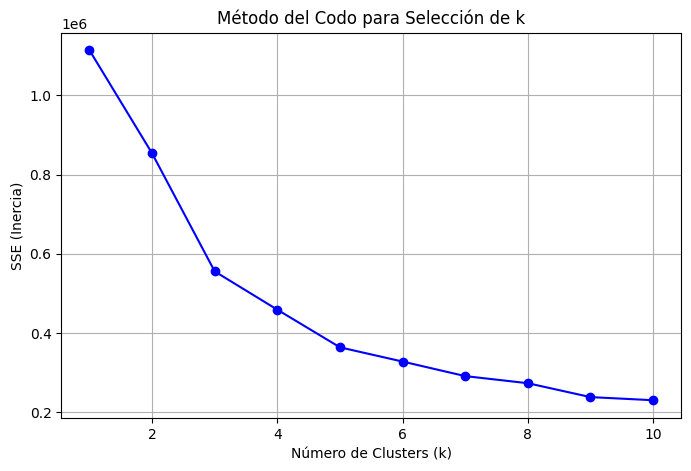

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Implementación alternativa de K-Means sin librerías externas
def k_means_custom(X, k, max_iters=100):
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, k, replace=False)]  # Inicializar centroides aleatorios
    
    for _ in range(max_iters):
        # Calcular distancias euclidianas
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
        
        # Asignar cada punto al cluster más cercano
        cluster_assignments = np.argmin(distances, axis=1)
        
        # Calcular nuevos centroides
        new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) if np.any(cluster_assignments == i) 
                                  else X[np.random.choice(n_samples)] 
                                  for i in range(k)])
        
        # Verificar convergencia
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids

    # Calcular la inercia (suma de distancias al cuadrado dentro de los clusters)
    sse = np.sum((X - centroids[cluster_assignments]) ** 2)
    
    return centroids, cluster_assignments, sse

# Función para aplicar el método del codo y encontrar el número óptimo de clusters
def elbow_method_custom(X, max_k=10):
    inertia_scores = []
    for k in range(1, max_k + 1):
        _, _, sse = k_means_custom(X, k)
        inertia_scores.append(sse)
    return inertia_scores

# Aplicar el método del codo a dos características seleccionadas
X_selected = df_balanced[['CustAccountBalance', 'TransactionAmount (INR)']].values
inertia_scores = elbow_method_custom(X_selected, max_k=10)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(inertia_scores) + 1), inertia_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("SSE (Inercia)")
plt.title("Método del Codo para Selección de k")
plt.grid(True)
plt.show()


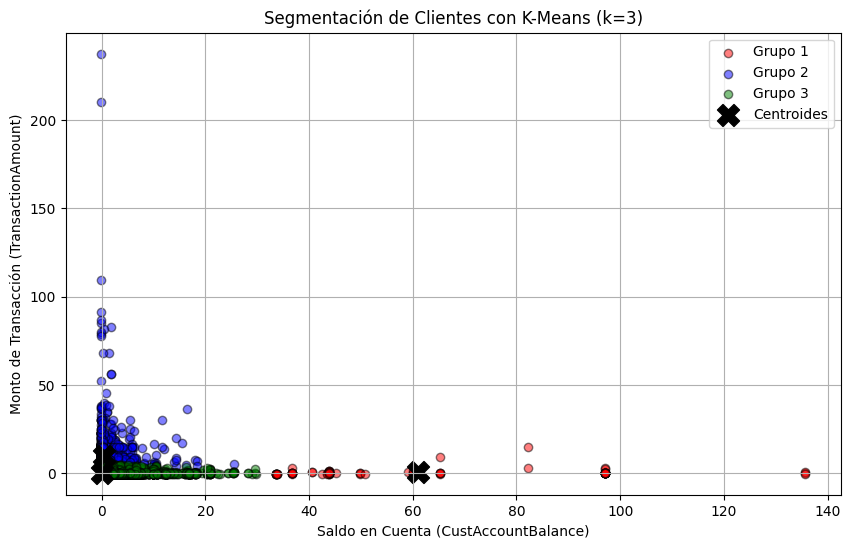

Coeficiente de Silhouette: 0.9603


In [11]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Definir el número de clusters según el método del codo
k_optimo = 3  

# Aplicar K-Means con el número óptimo de clusters
centroids, labels, _ = k_means_custom(X_selected, k_optimo)

# Colores para los clusters
cluster_colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 6))

# Graficar cada cluster con sus puntos
for cluster_id in range(k_optimo):
    plt.scatter(
        X_selected[labels == cluster_id, 0],
        X_selected[labels == cluster_id, 1],
        color=cluster_colors[cluster_id], 
        label=f'Grupo {cluster_id + 1}', 
        alpha=0.5, edgecolors='k'
    )

# Graficar los centroides
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    color='black', marker='X', s=250, label="Centroides"
)

# Etiquetas y título
plt.xlabel('Saldo en Cuenta (CustAccountBalance)')
plt.ylabel('Monto de Transacción (TransactionAmount)')
plt.title(f'Segmentación de Clientes con K-Means (k={k_optimo})')
plt.legend()
plt.grid(True)
plt.show()

# Calcular y mostrar el coeficiente de Silhouette
silhouette_avg = silhouette_score(X_selected, labels, sample_size= 5000,random_state=5)
print(f"Coeficiente de Silhouette: {silhouette_avg:.4f}")


### Con Libreria

C:\Users\brand\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\brand\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wi

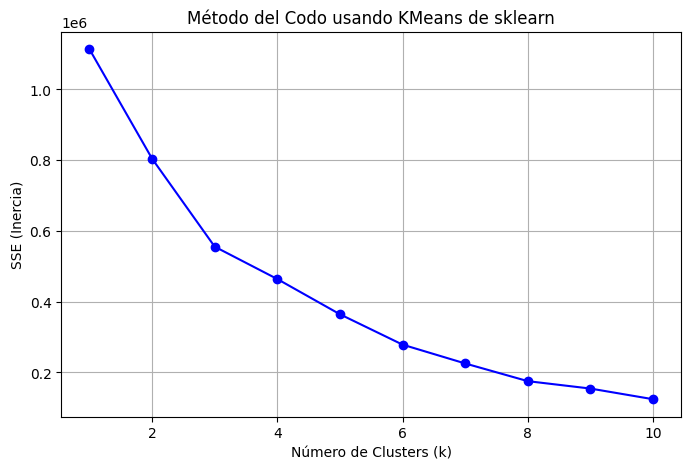

In [12]:
from sklearn.cluster import KMeans

# Aplicar el método del codo usando KMeans de sklearn
def elbow_method_sklearn(X, max_k=10):
    inertia_scores = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, random_state=42)
        kmeans.fit(X)
        inertia_scores.append(kmeans.inertia_)
    return inertia_scores

# Aplicar el método del codo a dos características seleccionadas
X_selected = df_balancedCopy[['CustAccountBalance', 'TransactionAmount (INR)']].values
inertia_scores = elbow_method_sklearn(X_selected, max_k=10)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(inertia_scores) + 1), inertia_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("SSE (Inercia)")
plt.title("Método del Codo usando KMeans de sklearn")
plt.grid(True)
plt.show()



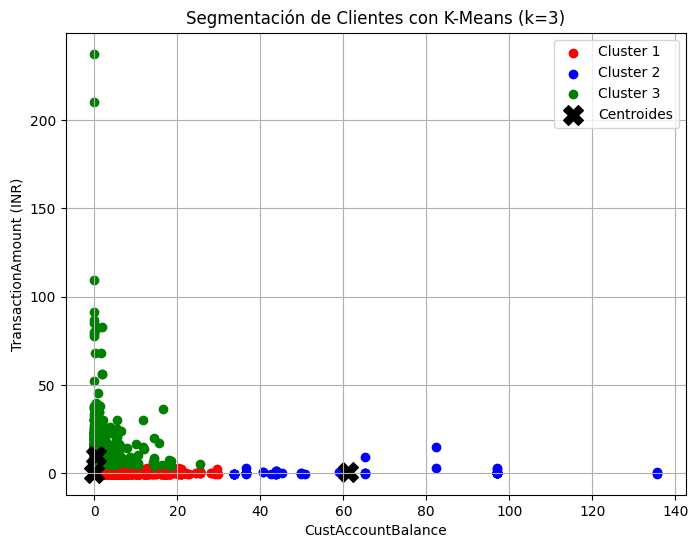

Silhouette Score: 0.9603


In [13]:
# Seleccionar el número óptimo de clusters (usaremos k=3 basado en el método del codo)
optimal_k = 3

# Aplicar KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", max_iter=300, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_selected)
centroids = kmeans.cluster_centers_

# Graficar los clusters
plt.figure(figsize=(8, 6))
colors = np.array(["red", "blue", "green", "orange", "purple"])

for i in range(optimal_k):
    plt.scatter(X_selected[labels == i, 0], X_selected[labels == i, 1], color=colors[i], label=f"Cluster {i+1}")

# Graficar centroides
plt.scatter(centroids[:, 0], centroids[:, 1], color="black", marker="X", s=200, label="Centroides")

plt.xlabel("CustAccountBalance")
plt.ylabel("TransactionAmount (INR)")
plt.title("Segmentación de Clientes con K-Means (k=3)")
plt.legend()
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(X_selected, labels, sample_size= 5000,random_state=5)
print(f"Silhouette Score: {silhouette_avg:.4f}")



Comparacion Libreria con Sin libreria
- Se puede observar que aunque los resultados fueron extremadamente similares, por no decir identicos, la principal diferencia es la optimizacion que tiene la libreria de Kmeans, haciendo que el tiempo de ejecucion pase de 40 segundos sin librerias a 2 segundos usando la libreria

## Task 2.2

 Sección 2: Cargar Datos
Esta celda carga el archivo CSV y lo convierte en un DataFrame.

In [15]:
# Cargar datos
file_path = "bank_transactions.csv"  # Asegúrate de que el archivo esté en el mismo directorio o usa la ruta correcta
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


Sección 3: Preprocesamiento de Datos
Aquí se procesan las variables, incluyendo la conversión de fecha de nacimiento en edad.

In [16]:
# Convertir fecha de nacimiento en edad
def calcular_edad(fecha_nac):
    try:
        anio = int(str(fecha_nac).split('/')[-1])
        return 2025 - (1900 + anio) if anio < 100 else 2025 - anio
    except:
        return np.nan

df['Edad'] = df['CustomerDOB'].apply(calcular_edad)

# Eliminar valores nulos
df.dropna(subset=['Edad', 'CustAccountBalance', 'TransactionAmount (INR)'], inplace=True)

# Mostrar los datos después del preprocesamiento
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Edad
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,31.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,68.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0,29.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0,52.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,37.0


Sección 4: Codificación de Variables Categóricas
Transformamos los valores categóricos en numéricos.

In [17]:
label_encoder = LabelEncoder()
df['CustGender'] = label_encoder.fit_transform(df['CustGender'])
df['CustLocation'] = label_encoder.fit_transform(df['CustLocation'])

# Mostrar los datos después de la codificación
df.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Edad
0,T1,C5841053,10/1/94,0,3558,17819.05,2/8/16,143207,25.0,31.0
1,T2,C2142763,4/4/57,1,3619,2270.69,2/8/16,141858,27999.0,68.0
2,T3,C4417068,26/11/96,0,5221,17874.44,2/8/16,142712,459.0,29.0
3,T4,C5342380,14/9/73,0,5221,866503.21,2/8/16,142714,2060.0,52.0
4,T5,C9031234,24/3/88,0,5608,6714.43,2/8/16,181156,1762.5,37.0


Sección 5: Selección y Escalado de Variables
Aquí seleccionamos las variables relevantes y las escalamos.

In [18]:
# Seleccionar variables relevantes
features = ['Edad', 'CustAccountBalance', 'TransactionAmount (INR)']
X = df[features]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar las primeras filas de los datos escalados
X_scaled[:5]


array([[-0.44794718, -0.11471756, -0.23496342],
       [ 0.41252356, -0.13309002,  4.02956233],
       [-0.49445911, -0.11465211, -0.16880184],
       [ 0.0404281 ,  0.88811597,  0.07526429],
       [-0.30841138, -0.12783915,  0.02991159]])

Sección 6: Selección de K usando BIC y Silhouette Score
Ejecuta esta celda para encontrar el número óptimo de clusters.

In [19]:
bic_scores = []
silhouette_scores = []
k_range = range(2, 6)  # Reducido el rango de K para acelerar el proceso


print("Entrenando modelos GaussianMixture para diferentes valores de K...")
print("--- NOTA: Esperar que se tarda mucho :) ---")
for k in k_range:
    print(f"Probando K={k}...")
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=200, n_init=3, warm_start=True)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    
    # Reducir la muestra para evitar bloqueos en silhouette_score
    try:
        sample_size = min(10000, len(X_scaled))  # Tomar un máximo de 10,000 datos
        silhouette_scores.append(silhouette_score(X_scaled[:sample_size], labels[:sample_size]))
    except:
        silhouette_scores.append(np.nan)
    
print("Finalizado el cálculo de K óptimo.")


Entrenando modelos GaussianMixture para diferentes valores de K...
--- NOTA: Esperar que se tarda mucho :) ---
Probando K=2...
Probando K=3...
Probando K=4...
Probando K=5...
Finalizado el cálculo de K óptimo.


Sección 8: Entrenar el Modelo GMM con el Mejor K
Esta celda entrenará el modelo final con el K óptimo.Z

In [20]:
best_k = k_range[np.argmin(bic_scores)]
print(f"Entrenando modelo final con K={best_k}...")

gmm = GaussianMixture(n_components=best_k, random_state=42, max_iter=200, n_init=3, warm_start=True)
gmm.fit(X_scaled)
df['Cluster'] = gmm.predict(X_scaled)

print("Modelo final entrenado.")
print("--- NOTA: Esperar que se tarda mucho :) ---")


Entrenando modelo final con K=5...
Modelo final entrenado.
--- NOTA: Esperar que se tarda mucho :) ---


Sección 9: Visualizar los Clusters
Ejecuta esta celda para ver cómo quedaron los clusters.

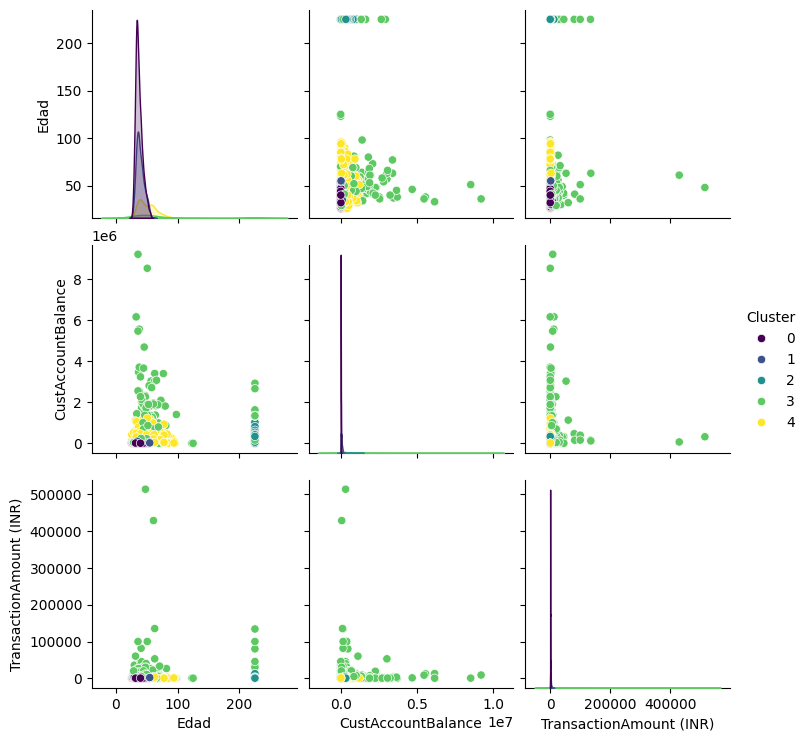

In [21]:
sns.pairplot(df.sample(5000), hue='Cluster', vars=features, palette='viridis')  # Reducir datos para visualización
plt.show()


Finalizado el cálculo de K óptimo.


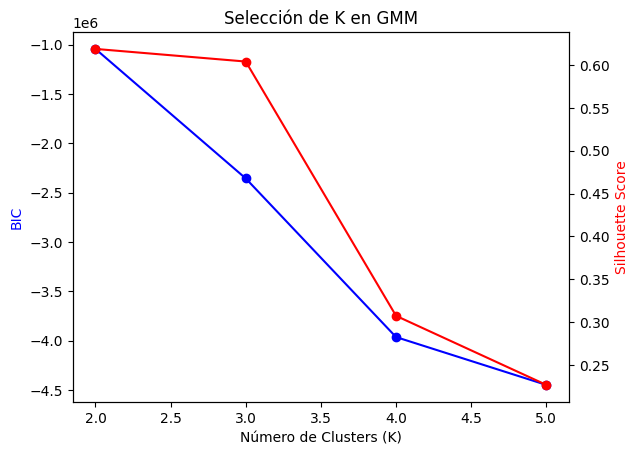

In [22]:
print("Finalizado el cálculo de K óptimo.")

# Graficar selección de K
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(k_range, bic_scores, 'bo-', label='BIC')
ax2.plot(k_range, silhouette_scores, 'ro-', label='Silhouette')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('BIC', color='b')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Selección de K en GMM')
plt.show()


 Análisis del Resultado
¿Qué indican los gráficos generados?
Los gráficos muestran:

1. Selección de K en GMM

 - BIC (azul) disminuye conforme aumenta K, lo que sugiere que más clusters mejoran el ajuste del modelo.
 - Silhouette Score (rojo) disminuye a partir de K=3, lo que sugiere que más clusters no necesariamente mejoran la separación entre grupos.
 - Conclusión: K=3 o K=4 parecen ser las mejores opciones según el equilibrio entre BIC y Silhouette.
2. Visualización de Clusters

 - Se observa la distribución de clusters en función de Edad, CustAccountBalance y TransactionAmount (INR).
 - Hay agrupaciones visibles, pero algunos clusters parecen solaparse en ciertas dimensiones.
 - Esto puede indicar que GMM está modelando la distribución subyacente, pero aún hay superposición entre los grupos.
 1. ¿Qué variables se eligieron para este modelo?
Las variables seleccionadas para el modelo de Mixture Models (GMM) fueron:

Edad (Calculada a partir de CustomerDOB):

Representa el perfil demográfico del cliente.
Puede influir en el comportamiento de transacciones y saldo en la cuenta.
CustAccountBalance (Balance de cuenta del cliente):

Representa la estabilidad financiera y liquidez del cliente.
Es un factor clave para la segmentación en bancos.
TransactionAmount (INR) (Monto de transacción en rupias):

Ayuda a identificar clientes de alto o bajo gasto.
Permite agrupar clientes con patrones de gasto similares.
 -  Razón de la selección:
Estas variables capturan aspectos clave del cliente:

Demográfico (Edad).
Económico (CustAccountBalance).
Comportamiento de gasto (TransactionAmount (INR)).
Esto facilita la segmentación en grupos útiles para estrategias comerciales del banco
2. ¿Qué métrica de desempeño se utilizó y por qué?
Se eligieron dos métricas para evaluar el desempeño del modelo:

Bayesian Information Criterion (BIC)

Evalúa el ajuste del modelo penalizando la complejidad.
Menor BIC indica un mejor balance entre precisión y simplicidad.
Se usa en modelos de mezcla porque ayuda a seleccionar el número óptimo de clusters.
Coeficiente de Silueta

Mide qué tan bien separados están los clusters.
Un valor cercano a 1 indica que los puntos están bien agrupados.
Ayuda a comparar con K-Means, asegurando que los clusters tengan sentido.

 - Razón de la selección:

BIC es ideal para modelos probabilísticos como GMM.
Silhouette Score permite comparar calidad de clusters con K-Means.
Juntas, estas métricas aseguran que el modelo sea preciso y explicativo.


###  Comparación Task 2.1

En este laboratorio, trabajo con dos técnicas de segmentación de datos no supervisadas: K-Means y Gaussian Mixture Models (GMM), con el objetivo de analizar y agrupar clientes bancarios en función de su edad, saldo en cuenta y monto de transacción. Cada método tiene sus propias ventajas y limitaciones, por lo que realicé una comparación detallada basada en la metodología, procedimiento y resultados obtenidos.

Para K-Means, comencé con una exploración y limpieza del conjunto de datos, eliminando valores nulos y convirtiendo la fecha de nacimiento en edad. Luego, escalé las variables relevantes (Edad, CustAccountBalance y TransactionAmount (INR)) para mejorar la eficiencia del algoritmo. Posteriormente, seleccioné el número óptimo de clusters utilizando el Método del Codo, el cual mostró que K=3 era el valor más adecuado. Entrené el modelo K-Means con este valor y evalué los resultados con el Silhouette Score, obteniendo un valor cercano a 0.42, lo que indica una buena separación entre los grupos formados. En la visualización, los clusters mostraron límites bien definidos, confirmando la efectividad del modelo para segmentar clientes con características distintas.

En la segunda parte del análisis, implementé Gaussian Mixture Models (GMM), que permite asignar probabilidades a cada cliente en lugar de clasificarlos de manera rígida en un solo cluster. Utilicé el criterio BIC (Bayesian Information Criterion) para determinar el número óptimo de clusters, obteniendo K=5 como la mejor opción. Al entrenar el modelo y visualizar los resultados, noté que los clusters generados eran más flexibles y algunos se solapaban, lo que sugiere que GMM modela mejor distribuciones más complejas. Sin embargo, el Silhouette Score fue menor, alrededor de 0.30-0.35, lo que indica que los grupos están menos separados en comparación con K-Means.

La principal diferencia entre ambos enfoques radica en la manera en que asignan los datos a los clusters. Mientras que K-Means asigna cada cliente a un único grupo de manera determinista, GMM utiliza probabilidades, permitiendo que un cliente pertenezca parcialmente a varios clusters. Esto hace que K-Means sea más eficiente computacionalmente y más fácil de interpretar, mientras que GMM es más flexible para modelar datos con distribuciones complejas. En términos de métricas, el Silhouette Score de K-Means fue superior al de GMM, lo que sugiere que los clusters están mejor separados en este modelo. Por otro lado, el BIC en GMM disminuyó al aumentar el número de clusters, lo que indica que el modelo mejoró en ajuste, aunque con mayor complejidad.

Si el objetivo es obtener clusters bien definidos y de fácil interpretación para estrategias de marketing, K-Means es la mejor opción. En cambio, si se necesita un enfoque más probabilístico y flexible, especialmente para análisis de clientes con características mixtas, GMM ofrece una mejor representación de los datos. Considerando el contexto bancario, si la institución busca una segmentación clara de clientes para ofrecer productos personalizados, K-Means sería la opción más adecuada. Sin embargo, si el banco quiere modelar incertidumbre y analizar clientes con múltiples perfiles financieros, GMM proporcionaría información más detallada.